### Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.metrics import mean_squared_error
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools


### Load and visualize the data

Names of arrays: ['u', 'th']
Shape of u and th: (35000,) (35000,)
Reshaped data of u and th: (35000, 1) (35000, 1)


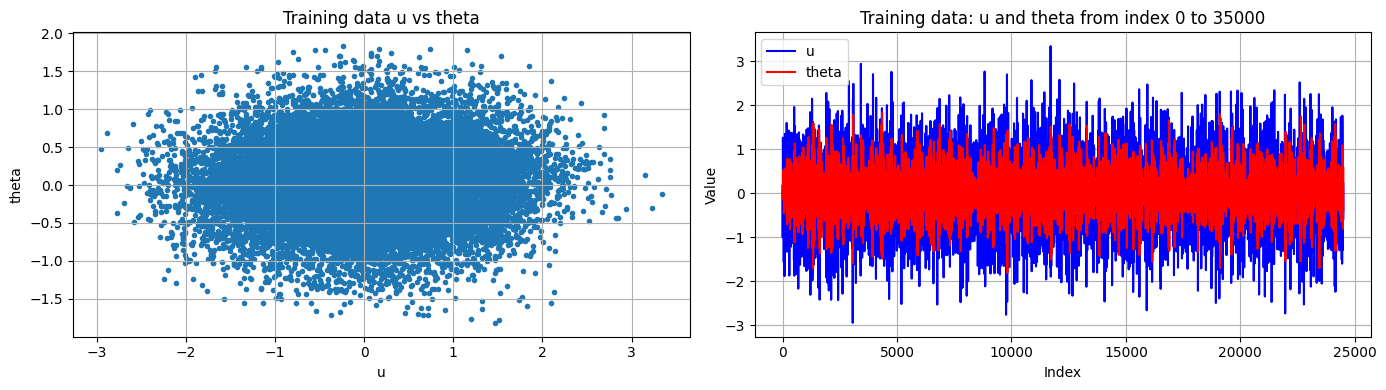

In [53]:
# Map the file names and paths
file_map = {
    "train_val_test": "disc-benchmark-files/training-val-test-data.npz",
    "hidden_test_pred": "disc-benchmark-files/hidden-test-prediction-submission-file.npz",
    "hidden_test_sim": "disc-benchmark-files/hidden-test-simulation-submission-file.npz"
}

file_name = file_map["train_val_test"]  

# Load the data 
data = np.load(file_name)
print("Names of arrays:", data.files)
print("Shape of u and th:", data['u'].shape, data['th'].shape)

# Reshape the data 
u = data['u'].reshape(-1,1)
th = data['th'].reshape(-1,1)
print("Reshaped data of u and th:", u.shape, th.shape)

# Define the division of the data for training, validation and testing
N = len(u)
train_percent = 0.70
val_test_percent = (1-train_percent) / 2

# Split data in training, testing and validation
n_train = int(train_percent * N)
n_val   = int(val_test_percent * N)

# Split dat in train val and test sets
u_train = u[:n_train]
u10_train = u10[:n_train]
y_train = th[:n_train]
y10_train = th10[:n_train]
u_val = u[n_train:n_train+n_val]
u10_val = u10[n_train:n_train+n_val]
y_val   = th[n_train:n_train+n_val]
y10_val   = th10[n_train:n_train+n_val]
u_test = u[n_train+n_val:] 
u10_test = u10[n_train+n_val:]
y_test  = th[n_train+n_val:]
y10_test  = th10[n_train+n_val:]

# Start and end index for plotting data data 
start, end = 0, len(data['u'])

# Define the subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot the data, scatter and line plot 
axs[0].scatter(u_train, y_train, marker='.')
axs[0].set_title('Training data u vs theta')
axs[0].set_xlabel('u')
axs[0].set_ylabel('theta')
axs[0].grid(True)

axs[1].plot(u_train[start:end], label='u', color='b')
axs[1].plot(y_train[start:end], label='theta', color='r')
axs[1].set_title(f'Training data: u and theta from index {start} to {end}')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Create hyperparameters and function for features

In [ ]:
# Hyperparameter ranges for random search
param_ranges = {
    'L_th': (2, 8),       
    'L_u': (2, 8),           
    'num_inducing': (1, 15) 
}

# Define number of trails for a random s
n_trials = 125

def build_features(u, th, L_th, L_u, max_lag, N_eff):
    # Initialize X and Y
    X = np.zeros((N_eff, L_th + L_u))
    Y = np.zeros(N_eff)
    # Fill in X and Y
    for i in range(N_eff):
        k = max_lag + i
        # past L_th thetas and L_u inputs
        y_lags = [th[k-j, 0] for j in range(1, L_th+1)]
        u_lags = [u [k-j, 0] for j in range(1, L_u +1)]
        X[i, :] = y_lags + u_lags
        Y[i] = th[k, 0]

    return X, Y

### Do a random grid search for optimal hyperparameters

Trial 1/25: L_th=7, L_u=4, inducing=14, resulting RMSE=0.0038785186653369514
Trial 2/25: L_th=8, L_u=5, inducing=15, resulting RMSE=0.003865986098118847
Trial 3/25: L_th=7, L_u=6, inducing=7, resulting RMSE=0.008076864834683771
Trial 4/25: L_th=2, L_u=8, inducing=1, resulting RMSE=0.40412865685963434
Trial 5/25: L_th=2, L_u=6, inducing=11, resulting RMSE=0.006722319432864358
Trial 6/25: L_th=4, L_u=8, inducing=8, resulting RMSE=0.005449894870969717
Trial 7/25: L_th=8, L_u=2, inducing=7, resulting RMSE=0.004140754918860392
Trial 8/25: L_th=4, L_u=6, inducing=11, resulting RMSE=0.004203038822288904
Trial 9/25: L_th=4, L_u=4, inducing=1, resulting RMSE=0.40281444402744704
Trial 10/25: L_th=4, L_u=3, inducing=3, resulting RMSE=0.011480774226791298
Trial 11/25: L_th=3, L_u=8, inducing=5, resulting RMSE=0.008815197731191106
Trial 12/25: L_th=7, L_u=6, inducing=14, resulting RMSE=0.003949208911733123
Trial 13/25: L_th=3, L_u=4, inducing=9, resulting RMSE=0.006814707191722358
Trial 14/25: L_th

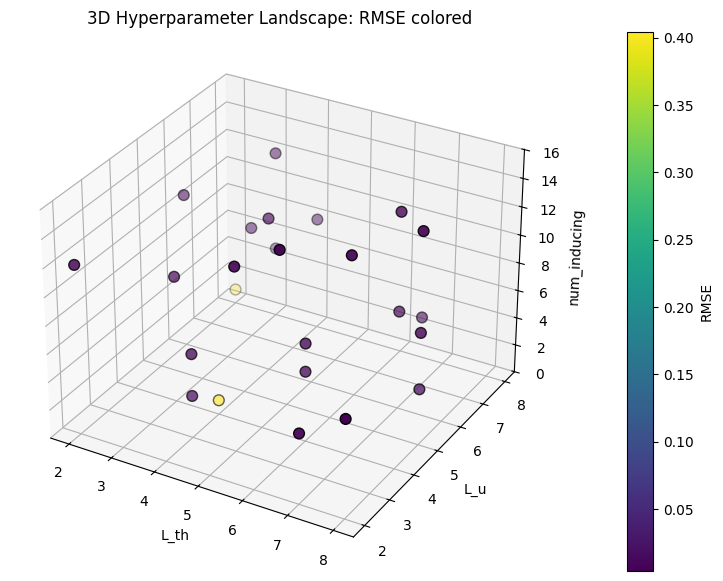

In [ ]:
# Define infinity for RMSE to optimize
best = {'rmse': np.inf}
results = []
# Loop over number of trails 
for t in range(n_trials):
    
    L_th = np.random.randint(param_ranges['L_th'][0], param_ranges['L_th'][1] + 1)
    L_u = np.random.randint(param_ranges['L_u'][0], param_ranges['L_u'][1] + 1)
    num_inducing = np.random.randint(param_ranges['num_inducing'][0], param_ranges['num_inducing'][1] + 1)
    max_lag = max(L_th, L_u)
    N_eff = len(u) - max_lag

    # Build features and splits based on sampled lags
    X_all, Y_all = build_features(u, th, L_th, L_u, max_lag, N_eff)
    train_end = N_eff - n_val
    X_train, Y_train = X_all[:train_end], Y_all[:train_end]
    X_val, Y_val = X_all[train_end:], Y_all[train_end:]

    # Train sparse GP
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
    # Randomly pick some inducing points from the training data 
    Z = X_train[np.random.choice(len(X_train), num_inducing, replace=False)]
    model = GPy.models.SparseGPRegression(X_train, Y_train[:, None], kernel=kernel, Z=Z)
    model.optimize(messages=False, max_iters=200)

    # Evaluate on validation set
    Y_pred, _ = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
    print(f"Trial {t+1}/{n_trials}: L_th={L_th}, L_u={L_u}, inducing={num_inducing}, resulting RMSE={rmse}")
    results.append((L_th, L_u, num_inducing, rmse))
    # Always keep the best hyperparameters
    if rmse < best['rmse']:
        best = {'L_th': L_th, 'L_u': L_u, 'num_inducing': num_inducing, 'rmse': rmse}

print("Best hyperparameters found:", best)

df = pd.DataFrame(results, columns=['L_th', 'L_u', 'num_inducing', 'rmse'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
p = ax.scatter(
    df['L_th'], df['L_u'], df['num_inducing'],
    c=df['rmse'], cmap='viridis', s=60, edgecolor='k'
)

ax.set_xlabel('L_th')
ax.set_ylabel('L_u')
ax.set_zlabel('num_inducing')
plt.title('3D Hyperparameter Landscape: RMSE colored')

# Add colorbar for RMSE values
cbar = plt.colorbar(p, pad=0.1)
cbar.set_label('RMSE')

plt.show()



In [63]:
import itertools

# Define grid search parameter values
L_th_values = np.arange(param_ranges['L_th'][0], param_ranges['L_th'][1] + 1, 1)
L_u_values = np.arange(param_ranges['L_u'][0], param_ranges['L_u'][1] + 1, 1)
num_inducing_values = np.linspace(param_ranges['num_inducing'][0], param_ranges['num_inducing'][1], 10, dtype=int)

results = []
best = {'rmse': np.inf}

for L_th, L_u, num_inducing in itertools.product(L_th_values, L_u_values, num_inducing_values):
    max_lag = max(L_th, L_u)
    N_eff = len(u) - max_lag

    X_all, Y_all = build_features(u, th, L_th, L_u, max_lag, N_eff)
    train_end = N_eff - n_val
    X_train, Y_train = X_all[:train_end], Y_all[:train_end]
    X_val, Y_val = X_all[train_end:], Y_all[train_end:]

    kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
    # Pick inducing points randomly from train set
    Z = X_train[np.random.choice(len(X_train), num_inducing, replace=False)]
    model = GPy.models.SparseGPRegression(X_train, Y_train[:, None], kernel=kernel, Z=Z)
    model.optimize(messages=False, max_iters=200)

    Y_pred, _ = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

    results.append((L_th, L_u, num_inducing, rmse))

    if rmse < best['rmse']:
        best = {'L_th': L_th, 'L_u': L_u, 'num_inducing': num_inducing, 'rmse': rmse}

    print(f"L_th={L_th}, L_u={L_u}, num_inducing={num_inducing}, RMSE={rmse:.4f}")

print("Best hyperparameters found:", best)

# Convert results to DataFrame
df = pd.DataFrame(results, columns=['L_th', 'L_u', 'num_inducing', 'rmse'])

# Create empty 3D grid for RMSE
rmse_grid = np.full((len(L_th_values), len(L_u_values), len(num_inducing_values)), np.nan)

for i, L_th in enumerate(L_th_values):
    for j, L_u in enumerate(L_u_values):
        for k, num_ind in enumerate(num_inducing_values):
            val = df[
                (df['L_th'] == L_th) &
                (df['L_u'] == L_u) &
                (df['num_inducing'] == num_ind)
            ]['rmse']
            if not val.empty:
                rmse_grid[i, j, k] = val.values[0]

# Plot 2D heatmaps for each num_inducing slice
for k, num_ind in enumerate(num_inducing_values):
    plt.figure(figsize=(8, 6))
    slice_2d = rmse_grid[:, :, k]

    # Transpose to have L_u on y-axis and L_th on x-axis
    plt.imshow(slice_2d.T, origin='lower', aspect='auto',
               extent=[L_th_values[0], L_th_values[-1], L_u_values[0], L_u_values[-1]],
               cmap='viridis_r')
    plt.colorbar(label='RMSE')
    plt.title(f'RMSE Landscape (num_inducing={num_ind})')
    plt.xlabel('L_th')
    plt.ylabel('L_u')
    plt.show()

L_th=2, L_u=2, num_inducing=1, RMSE=0.3731
L_th=2, L_u=2, num_inducing=2, RMSE=0.0089
L_th=2, L_u=2, num_inducing=4, RMSE=0.0068
L_th=2, L_u=2, num_inducing=5, RMSE=0.0067
L_th=2, L_u=2, num_inducing=7, RMSE=0.0068
L_th=2, L_u=2, num_inducing=8, RMSE=0.0042
L_th=2, L_u=2, num_inducing=10, RMSE=0.0042
L_th=2, L_u=2, num_inducing=11, RMSE=0.0042
L_th=2, L_u=2, num_inducing=13, RMSE=0.0042
L_th=2, L_u=2, num_inducing=15, RMSE=0.0041
L_th=2, L_u=3, num_inducing=1, RMSE=0.3724
L_th=2, L_u=3, num_inducing=2, RMSE=0.0126
L_th=2, L_u=3, num_inducing=4, RMSE=0.0069
L_th=2, L_u=3, num_inducing=5, RMSE=0.0067
L_th=2, L_u=3, num_inducing=7, RMSE=0.0047
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

### Make the GP on the full dataset

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0001   3.859614e+04   4.848652e+07 
    02s18  0024  -9.689946e+04   2.342903e+08 
    08s28  0098  -1.165713e+05   2.663218e+08 
    25s78  0303  -1.200011e+05   3.174019e+06 
 01m12s77  0870  -1.217423e+05   2.905526e+06 
 01m23s66  1002  -1.218920e+05   1.144846e+06 
Runtime:  01m23s66
Optimization status: Maximum number of f evaluations reached



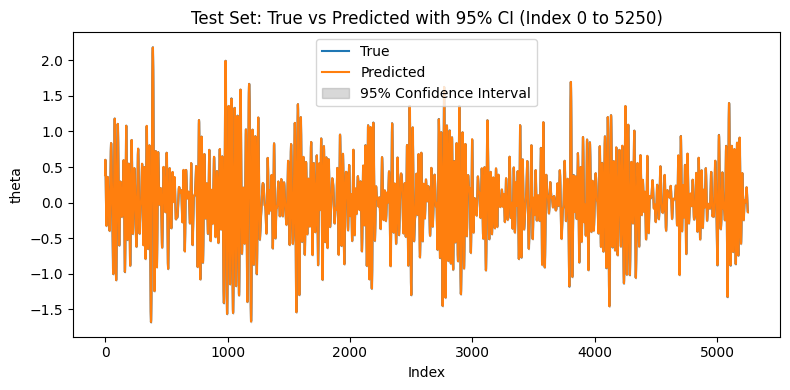

In [56]:
L_th_b, L_u_b, num_ind_b = best['L_th'], best['L_u'], best['num_inducing']
max_lag = max(L_th_b, L_u_b)
N_eff = len(u) - max_lag
X_all, Y_all = build_features(u, th, L_th_b, L_u_b, max_lag, N_eff)

n_eff_train = n_train - max_lag

X_tv, Y_tv = X_all[:n_eff_train + n_val], Y_all[:n_eff_train + n_val]
X_test, Y_test = X_all[n_eff_train + n_val:], Y_all[n_eff_train + n_val:]

start = 0
end = len(Y_test)

kernel = GPy.kern.RBF(input_dim=X_tv.shape[1], ARD=True)
Z_tv = X_tv[np.random.choice(len(X_tv), num_ind_b, replace=False)]
final_model = GPy.models.SparseGPRegression(X_tv, Y_tv[:, None], kernel=kernel, Z=Z_tv)
final_model.optimize(messages=True)

# Predict mean and variance on test set
Y_test_pred, Y_test_var = final_model.predict(X_test)
Y_test_std = np.sqrt(Y_test_var)

# Calculate 95% confidence interval bounds
lower_bound = Y_test_pred - 1.96 * Y_test_std
upper_bound = Y_test_pred + 1.96 * Y_test_std

plt.figure(figsize=(8, 4))
plt.plot(Y_test[start:end], label='True')
plt.plot(Y_test_pred[start:end], label='Predicted')
plt.fill_between(
    np.arange(start, end),
    lower_bound[start:end].flatten(),
    upper_bound[start:end].flatten(),
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title(f'Test Set: True vs Predicted with 95% CI (Index {start} to {end})')
plt.xlabel('Index')
plt.ylabel('theta')
plt.legend()
plt.tight_layout()
plt.show()


### Making GP on 10% of the dataset

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   2.494664e+03   5.531339e+05 
    00s17  0009   1.331632e+03   9.468754e+06 
    00s19  0010   6.709715e+02   7.698451e+05 
    01s20  0065  -1.843604e+03   1.622038e+03 
    05s24  0308  -1.928251e+03   1.311683e+02 
    11s27  0814  -1.948990e+03   2.221181e+01 
    13s74  1002  -1.952274e+03   4.877164e+01 
Runtime:     13s74
Optimization status: Maximum number of f evaluations reached



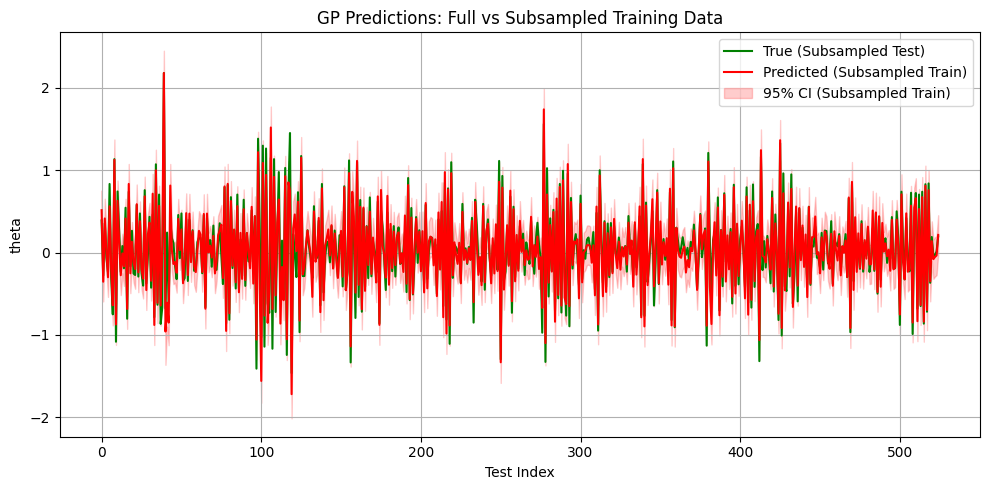

In [57]:
u10 = u[::10]
th10 = th[::10]

N_eff_10 = len(u10) - max_lag
X_all_10, Y_all_10 = build_features(u10, th10, best['L_th'], best['L_u'], max_lag, N_eff_10)

# New train/val/test split sizes for subsampled data (approx 10% points)
n_train_10 = int(train_percent * len(u10))
n_eff_train_10 = n_train_10 - max_lag

X_tv_10, Y_tv_10 = X_all_10[:n_eff_train_10 + int(val_test_percent * len(u10))], Y_all_10[:n_eff_train_10 + int(val_test_percent * len(u10))]
X_test_10, Y_test_10 = X_all_10[n_eff_train_10 + int(val_test_percent * len(u10)):], Y_all_10[n_eff_train_10 + int(val_test_percent * len(u10)):]

# Train GP on subsampled data
kernel_10 = GPy.kern.RBF(input_dim=X_tv_10.shape[1], ARD=True)
Z_tv_10 = X_tv_10[np.random.choice(len(X_tv_10), best['num_inducing'], replace=False)]
model_subsampled = GPy.models.SparseGPRegression(X_tv_10, Y_tv_10[:, None], kernel=kernel_10, Z=Z_tv_10)
model_subsampled.optimize(messages=True)


Y_test_pred_sub, Y_test_var_sub = model_subsampled.predict(X_test_10)
Y_test_std_sub = np.sqrt(Y_test_var_sub)

start, end = 0, len(Y_test)

plt.figure(figsize=(10, 5))

# Subsampled model predictions (on subsampled test set)
plt.plot(range(start, start + len(Y_test_10)), Y_test_10[start:], label='True (Subsampled Test)', color='green', linestyle='solid')
plt.plot(range(start, start + len(Y_test_pred_sub)), Y_test_pred_sub[start:], label='Predicted (Subsampled Train)', color='red', linestyle='solid')
plt.fill_between(
    np.arange(start, start + len(Y_test_pred_sub)),
    (Y_test_pred_sub - 1.96 * Y_test_std_sub).flatten()[start:],
    (Y_test_pred_sub + 1.96 * Y_test_std_sub).flatten()[start:],
    color='red',
    alpha=0.2,
    label='95% CI (Subsampled Train)'
)

plt.title('GP Predictions: Full vs Subsampled Training Data')
plt.xlabel('Test Index')
plt.ylabel('theta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicting on only 4% of the dataset

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   1.771933e+03   1.302194e+05 
    00s07  0006   7.899933e+02   3.485330e+04 
    00s19  0014   6.683779e+02   9.529333e+01 
    02s21  0230   6.465280e+02   5.978772e-01 
    05s22  0588   6.456042e+02   6.156498e+01 
    09s15  1002   6.452921e+02   4.704984e-03 
Runtime:     09s15
Optimization status: Maximum number of f evaluations reached



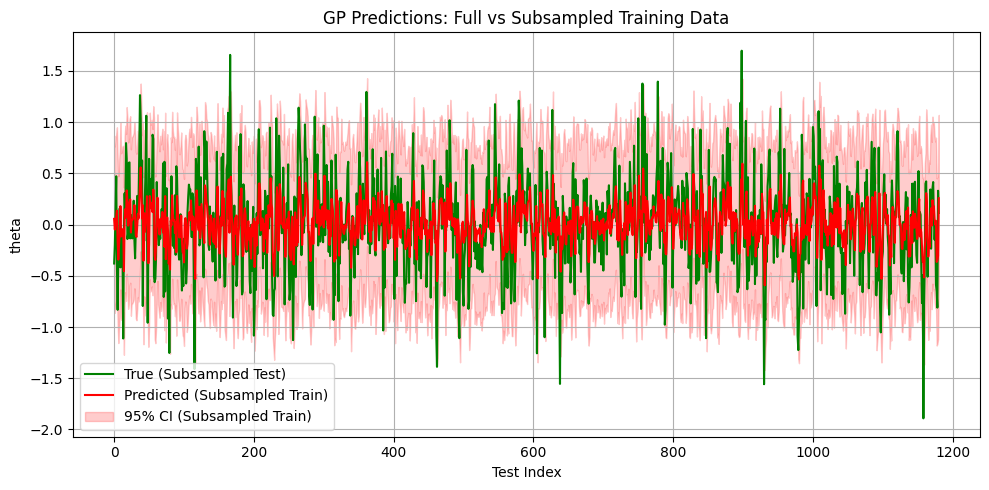

In [58]:
u25 = u[::25]
th25 = th[::25]

N_eff_25 = len(u25) - max_lag
X_all_25, Y_all_25 = build_features(u25, th25, best['L_th'], best['L_u'], max_lag, N_eff_25)

# New train/val/test split sizes for subsampled data (approx 25% points)
n_train_25 = int(train_percent * len(u25))
n_eff_train_25 = n_train_25 - max_lag

X_tv_25, Y_tv_25 = X_all_25[:n_eff_train_25 + int(val_test_percent * len(u25))], Y_all_25[:n_eff_train_25 + int(val_test_percent * len(u25))]
X_test_25, Y_test_25 = X_all_25[:n_eff_train_25 + int(val_test_percent * len(u25))], Y_all_25[:n_eff_train_25 + int(val_test_percent * len(u25)):]

# Train GP on subsampled data
kernel_25 = GPy.kern.RBF(input_dim=X_tv_25.shape[1], ARD=True)
Z_tv_25 = X_tv_25[np.random.choice(len(X_tv_25), best['num_inducing'], replace=False)]
model_subsampled = GPy.models.SparseGPRegression(X_tv_25, Y_tv_25[:, None], kernel=kernel_25, Z=Z_tv_25)
model_subsampled.optimize(messages=True)


Y_test_pred_sub, Y_test_var_sub = model_subsampled.predict(X_test_25)
Y_test_std_sub = np.sqrt(Y_test_var_sub)

start, end = 0, len(Y_test)

plt.figure(figsize=(10, 5))

# Subsampled model predictions (on subsampled test set)
plt.plot(range(start, start + len(Y_test_25)), Y_test_25[start:], label='True (Subsampled Test)', color='green', linestyle='solid')
plt.plot(range(start, start + len(Y_test_pred_sub)), Y_test_pred_sub[start:], label='Predicted (Subsampled Train)', color='red', linestyle='solid')
plt.fill_between(
    np.arange(start, start + len(Y_test_pred_sub)),
    (Y_test_pred_sub - 1.96 * Y_test_std_sub).flatten()[start:],
    (Y_test_pred_sub + 1.96 * Y_test_std_sub).flatten()[start:],
    color='red',
    alpha=0.2,
    label='95% CI (Subsampled Train)'
)

plt.title('GP Predictions: Full vs Subsampled Training Data')
plt.xlabel('Test Index')
plt.ylabel('theta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()